Dyna Q model, CVAE, reward model and terminal model trained

In [1]:
#this allows relative imports in notebook
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
name='Experiment1'

In [3]:
from UCLSE.dyna_q.Experiment1a import Experiment
from UCLSE.dyna_q.dyna_q import TabularMemory
from UCLSE.dyna_q.benchmarking import BenchmarkAgent, SpoofAgent, DoNothing
import numpy as np
import pandas as pd
import os
import torch
import visdom
import matplotlib.pyplot as plt

In [4]:
vis=visdom.Visdom(port=8097)

In [5]:
def reward_oracle(observation,cutoff=50,ub=6,lb=-2,lamb=0.5):


    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    bid_change=observation.bid_change
    bid_ask_spread=observation.bid_ask_spread
    time_left=observation.time_left

    ans=lamb*bid_change

    if inventory==0:   #terminal            
            
            ans+=-(1-lamb)*distance
            ans-=lamb*bid_change

    elif inventory>1: #terminal
            
            ans+=-bid_ask_spread*(inventory-1)
            ans+=-(1-lamb)*distance
            ans+=-1 #penalty
           
    else:

            if orders_out>0: 
                ans+=1/250


            if time_left==1: #terminal takes account of exit spread
               
                ans+=-(1-lamb)*distance

            if -distance>=ub:
                
                ans+=-(1-lamb)*distance
              

            elif -distance<lb:
               
                ans+=-(1-lamb)*distance
               

    return ans 

def done_oracle(observation,cutoff=50,lb=-2,ub=6):

    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    time_left=observation.time_left

    if inventory==0:
        done=1
        why=f'inventory {inventory}=0'
    elif time_left>=1:
        done=1
        why=f'time up {time_left}'
    elif inventory>1:
        done=1
        why=f'inventory {inventory}>1'
    elif -distance>=ub:
        done=1
        why=f'-distance {distance} >ub {ub}'
    elif -distance<lb: 
        done=1
        why=f'-distance {distance}<lb {lb}'

    else:
        done=0 
        why=None
    return done,why

In [6]:
trader_pref_kwargs={'qty_min':-5,'qty_max':5,'sigma_pv':1}
timer_kwargs={'start':0,'end':6000,'step':1}
price_sequence_kwargs={'kappa':0.0002,'mean':100,'sigma':1,'block_length':10}
noise_kwargs={'sigma':1}
messenger_kwargs={'logging':True}
env_kwargs={'trader_arrival_rate':1,'recording':True,#'process_verbose':False,
                'bookkeep_verbose':False, 'lob_verbose':False}
sigma_n=5

def cont_coef():
    return np.random.uniform(0.2,0.8)

def personal_memory():
    return int(np.random.uniform(5,15))

trader_kwargs={'ZIP':{'prefix':'ZIP','number':10,'object_name':'WW_Zip',
                          'setup_kwargs':
                                {'market_make':True,'prior':(100,sigma_n)}},
               'HBL':{'prefix':'HBL','number':10,'object_name':'HBL',
                          'setup_kwargs':
                              {'memory':100,'grace_period':20}},
               'CON':{'prefix':'CON','number':10,'object_name':'ContTrader',
                      'setup_kwargs':
                          {'cont_coeff':cont_coef,'personal_memory':personal_memory,'profit_target':4, 'market_make':True,
                          'prior':(100,sigma_n)}},
               'NOI':{'prefix':'NOI','number':10,'object_name':'NoiseTrader',
                          'setup_kwargs':{'memory':20}}
              }

lobenv_kwargs={'cutoff':100,'profit_target':10,'loss_limit':-1,'reward_func':reward_oracle,'lamb':0.5}
agent_kwargs={'CVAE':True,'Q_H1Size':16,'Q_H2Size':16,'latent_dim':3,'recon_weight':0.1,'kl_thresh':0.01,
                   'env_H1Size':16,'env_H2Size':16,
                   'doneModel':True,'rewardModel':None,'loss_func':None}


In [7]:
dyna_config={
	"double_q_model": False,
	"batch_size": 64,
	"learning_rate": 5e-3,
	"exploration": {
		"type": "exponential",
		"init_epsilon": 0.8,
		"min_epsilon": 0.05,
		"decay_steps": 100000,
		"decay_eps": 0.99,
        "choice":'least_bonus'
	},
	"memory": {
		"memory_capacity": 1000000,
		"prioritized": False,
        "tabular memory":True,
        
	},
	"discount": 0.99,
	"target_update_freq": 50,
	"first_update": 200,
	"modify_reward": False,
    "learn":'Q',
    'double_q_model':True,
    'model_update_freq':5,
    'planning_freq':5,
    'model':'CVAE'
    
}

In [8]:
experiment=Experiment(trader_pref_kwargs=trader_pref_kwargs,timer_kwargs=timer_kwargs,
           price_sequence_kwargs=price_sequence_kwargs,noise_kwargs=noise_kwargs,
           messenger_kwargs=messenger_kwargs,env_kwargs=env_kwargs,trader_kwargs=trader_kwargs,
           lobenv_kwargs=lobenv_kwargs,agent_kwargs=agent_kwargs,visdom=vis,dyna_kwargs=dyna_config,name=name)

sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
setup tabular memory


In [10]:
experiment.new_train_setup(MaxEpisodes=1000,planning_steps=1,lookback=30,thresh=3,planning=True,graph=True)

In [18]:
experiment.agent.set_device()
experiment.train(MaxEpisodes=10001,start_episode=experiment.episode,folder='Results/'+experiment.name)

Device in use is  cuda
Planning is True, double Q model is True, tabular memory is True
Saving best checkpoint at episode 2098 with reward 1.0626476229071153
not strict double Q model
Dyna-Q - EXP: 1 | Ep: 2101 | timestep: 57 | Ep_r:  -1.7695684700262264 Profit: -3 Avg loss:0.891748312847208
Dyna-Q - EXP: 1 | Ep: 2121 | timestep: 87 | Ep_r:  -1.6492266099719513 Profit: -3 Avg loss:-0.2563660353183695
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 2141 | timestep: 9 | Ep_r:  1.0255931010065436 Profit: 0 Avg loss:-0.12705248446114384
Dyna-Q - EXP: 1 | Ep: 2161 | timestep: 63 | Ep_r:  1.1786377828179546 Profit: 0 Avg loss:0.10213615838569264
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 2181 | timestep: 8 | Ep_r:  1.0219021222288318 Profit: 0 Avg loss:0.17449459244002755
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
a

Dyna-Q - EXP: 1 | Ep: 3061 | timestep: 8 | Ep_r:  1.0219021222288318 Profit: 0 Avg loss:0.8303963949103857
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 3081 | timestep: 7 | Ep_r:  1.0181738608372042 Profit: 0 Avg loss:0.618013343795196
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 3101 | timestep: 21 | Ep_r:  -1.860330538415663 Profit: -3 Avg loss:0.325315530357576
Dyna-Q - EXP: 1 | Ep: 3121 | timestep: 11 | Ep_r:  1.0328646982965135 Profit: -4 Avg loss:0.39120450791779654
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 3141 | timestep: 10 | Ep_r:  1.0292471699964783 Profit: 0 Avg loss:0.6096244410309156
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 3161 | timestep: 8 | Ep_r:  2.016902122228832 Profit: 1 Avg loss:0.572141453527326
sequence made
adding exchange to RL trader  RL
adding 

Dyna-Q - EXP: 1 | Ep: 4021 | timestep: 19 | Ep_r:  -1.8826640162980557 Profit: 21 Avg loss:0.3885540562609647
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 4041 | timestep: 4 | Ep_r:  1.006761596 Profit: 0 Avg loss:0.44575000003680704
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 4061 | timestep: 17 | Ep_r:  -0.9096808367638075 Profit: -2 Avg loss:0.349871015174817
Dyna-Q - EXP: 1 | Ep: 4081 | timestep: 13 | Ep_r:  1.0703450711671554 Profit: -2 Avg loss:0.499977623041417
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 4101 | timestep: 11 | Ep_r:  -1.992198404 Profit: -3 Avg loss:0.28261308311737743
Dyna-Q - EXP: 1 | Ep: 4121 | timestep: 55 | Ep_r:  1.131391950115566 Profit: 0 Avg loss:-0.0395951074417577
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 4141 

Dyna-Q - EXP: 1 | Ep: 4981 | timestep: 3 | Ep_r:  0.008910000000000008 Profit: -1 Avg loss:0.36267074917573744
Dyna-Q - EXP: 1 | Ep: 5001 | timestep: 10 | Ep_r:  0.9916595172104381 Profit: -2 Avg loss:0.49312980227737474
Saving checkpoint at episode 5000
not strict double Q model
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 5021 | timestep: 6 | Ep_r:  1.0144079402396 Profit: 0 Avg loss:0.6861540673746221
Dyna-Q - EXP: 1 | Ep: 5041 | timestep: 22 | Ep_r:  -1.8976847989111303 Profit: -5 Avg loss:0.5806555178438461
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 5061 | timestep: 52 | Ep_r:  2.006645566117415 Profit: 1 Avg loss:0.17370584469762324
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 5081 | timestep: 21 | Ep_r:  0.9844894320104085 Profit: 0 Avg loss:0.5411

Dyna-Q - EXP: 1 | Ep: 5941 | timestep: 16 | Ep_r:  1.0082155153038703 Profit: 0 Avg loss:0.1872108910151305
Dyna-Q - EXP: 1 | Ep: 5961 | timestep: 13 | Ep_r:  -1.7006914794415169 Profit: -3 Avg loss:0.3668879846941292
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 5981 | timestep: 46 | Ep_r:  2.1039090310118986 Profit: 1 Avg loss:0.5676588465060246
Dyna-Q - EXP: 1 | Ep: 6001 | timestep: 26 | Ep_r:  1.006761596 Profit: 0 Avg loss:0.2687069562221169
Saving checkpoint at episode 6000
not strict double Q model
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 6021 | timestep: 3 | Ep_r:  1.0028804 Profit: -2 Avg loss:0.6389968786246161
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 6041 | timestep: 48 | Ep_r:  -1.7669835369659195 Profit: -5 Avg loss:0.38261869419859473
c

Dyna-Q - EXP: 1 | Ep: 6921 | timestep: 13 | Ep_r:  1.0399915908004127 Profit: 0 Avg loss:0.3507733197742319
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 6941 | timestep: 37 | Ep_r:  1.1115662966624342 Profit: 0 Avg loss:0.493506240727205
Dyna-Q - EXP: 1 | Ep: 6961 | timestep: 10 | Ep_r:  1.0252871699964783 Profit: 0 Avg loss:0.7570069117612303
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 6981 | timestep: 3 | Ep_r:  0.0 Profit: -1 Avg loss:0.9734436133779055
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 7001 | timestep: 11 | Ep_r:  2.027864698296513 Profit: 1 Avg loss:0.8675784948289507
Saving checkpoint at episode 7000
not strict double Q model
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 7021 | timestep: 1 | Ep_r:  0.0 Profit: -1 Avg loss:0.71568767

adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 7921 | timestep: 30 | Ep_r:  -1.658939646771428 Profit: -3 Avg loss:0.6528890974251218
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 7941 | timestep: 3 | Ep_r:  1.0028804 Profit: -2 Avg loss:0.7445493926109351
Dyna-Q - EXP: 1 | Ep: 7961 | timestep: 2 | Ep_r:  0.0 Profit: -1 Avg loss:0.4684918664382981
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 7981 | timestep: 2 | Ep_r:  0.0 Profit: -1 Avg loss:0.39826097664686444
Dyna-Q - EXP: 1 | Ep: 8001 | timestep: 10 | Ep_r:  1.0449481848468782 Profit: 0 Avg loss:0.32744132461724124
Saving checkpoint at episode 8000
not strict double Q model
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 8021 | timestep: 18 | Ep_r:  1.9866941107504732 Profit: 1 Avg loss:0.24278756707589816
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trade

Dyna-Q - EXP: 1 | Ep: 8921 | timestep: 25 | Ep_r:  0.07699105624034129 Profit: -1 Avg loss:0.702441472885376
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 8941 | timestep: 28 | Ep_r:  0.08630990107854691 Profit: -1 Avg loss:0.4017697387989755
Dyna-Q - EXP: 1 | Ep: 8961 | timestep: 47 | Ep_r:  1.1418478487429602 Profit: -2 Avg loss:0.42622677261220265
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 8981 | timestep: 8 | Ep_r:  1.018098162029232 Profit: 0 Avg loss:0.8220433973495146
Saving best checkpoint at episode 8992 with reward 1.205400471804627
not strict double Q model
Dyna-Q - EXP: 1 | Ep: 9001 | timestep: 5 | Ep_r:  1.0028804 Profit: 0 Avg loss:1.1497840354231716
Saving checkpoint at episode 9000
not strict double Q model
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding excha

Dyna-Q - EXP: 1 | Ep: 9861 | timestep: 10 | Ep_r:  2.024247169996478 Profit: 1 Avg loss:0.5489109057919405
Dyna-Q - EXP: 1 | Ep: 9881 | timestep: 13 | Ep_r:  1.0399915908004127 Profit: 0 Avg loss:0.7421257233080403
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 9901 | timestep: 6 | Ep_r:  1.0105267442396 Profit: 0 Avg loss:0.7007991767571704
Dyna-Q - EXP: 1 | Ep: 9921 | timestep: 79 | Ep_r:  1.2234481036244438 Profit: 0 Avg loss:0.2961703830427735
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 9941 | timestep: 9 | Ep_r:  2.0205931010065434 Profit: 1 Avg loss:1.0909991759787336
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 9961 | timestep: 1 | Ep_r:  0.2475 Profit: -2 Avg loss:0.8000218207543426
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 9981 | timestep

In [19]:
experiment.resume(exp=experiment,best=True,folder='Results/'+experiment.name)

=> loading checkpoint 'Results/Experiment1\dyna_best.pth.tar'
=> loaded checkpoint 'Results/Experiment1\dyna_best.pth.tar' (epoch 9680)
not double Q
keys unused in checkpoint data:  ['episode', 'setup']


In [20]:
experiment.agent.set_device('cpu')
experiment.test_setup(MaxEpisodes=5000)

Device in use is  cpu
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
setup tabular memory
Dyna-Q - EXP 1, | Ep: , 1, | timestep:  11 | Ep_r: 1.0328646982965135|profit:0 start:263|end:274
Dyna-Q - EXP 1, | Ep: , 11, | timestep:  10 | Ep_r: -0.9950127553030217|profit:-2 start:1675|end:1685
Dyna-Q - EXP 1, | Ep: , 21, | timestep:  15 | Ep_r: 2.0419766581434846|profit:1 start:3180|end:3195
r0 0.5
Dyna-Q - EXP 1, | Ep: , 31, | timestep:  7 | Ep_r: 1.0181738608372042|profit:0 start:4575|end:4582
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 41, | timestep:  52 | Ep_r: -1.0133569682735282|profit:0 start:754|end:806
Dyna-Q - EXP 1, | Ep: , 51, | timestep:  14 | Ep_r: 1.0780889821606536|profit:0 start:2578|end:2592
Dyna-Q - EXP 1, | Ep: , 61, | timestep:  16 | Ep_r: -0.9785504344844552|profit:-1 start:3994|end:4010
r0 0.5
r0 1.0
sequence made
adding exchange to RL trader  RL


Dyna-Q - EXP 1, | Ep: , 641, | timestep:  19 | Ep_r: 1.0566121504657653|profit:0 start:1607|end:1626
Dyna-Q - EXP 1, | Ep: , 651, | timestep:  8 | Ep_r: 2.016902122228832|profit:1 start:3394|end:3402
r0 0.5
Dyna-Q - EXP 1, | Ep: , 661, | timestep:  9 | Ep_r: 2.0205931010065434|profit:1 start:5086|end:5095
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 671, | timestep:  14 | Ep_r: 1.0582838686995106|profit:0 start:1853|end:1867
r0 0.5
Dyna-Q - EXP 1, | Ep: , 681, | timestep:  100 | Ep_r: 1.769221001537244|profit:1 start:3502|end:3602
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 691, | timestep:  7 | Ep_r: -1.976826139162796|profit:-3 start:282|end:289
Dyna-Q - EXP 1, | Ep: , 701, | timestep:  34 | Ep_r: -2.9751369789911237|profit:-3 start:2157|end:2191
Dyna-Q - EXP 1, | Ep: , 711, | timestep:  22 | Ep_r: 2.0363804381378765|profit:1 start:3537|end:3559
Dyna-Q - EXP 1, | Ep:

Dyna-Q - EXP 1, | Ep: , 1281, | timestep:  13 | Ep_r: 3.029991590800413|profit:2 start:3777|end:3790
Dyna-Q - EXP 1, | Ep: , 1291, | timestep:  41 | Ep_r: -3.5812656810791585|profit:-3 start:5059|end:5100
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1301, | timestep:  35 | Ep_r: 1.106180688581607|profit:0 start:1148|end:1183
Dyna-Q - EXP 1, | Ep: , 1311, | timestep:  18 | Ep_r: 2.018566842633925|profit:1 start:3063|end:3081
Dyna-Q - EXP 1, | Ep: , 1321, | timestep:  17 | Ep_r: 2.0488227226464293|profit:1 start:4698|end:4715
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1331, | timestep:  18 | Ep_r: -1.6825673148273632|profit:-1 start:1219|end:1237
Dyna-Q - EXP 1, | Ep: , 1341, | timestep:  61 | Ep_r: 1.1933743784992736|profit:0 start:2411|end:2472
r0 0.5
Dyna-Q - EXP 1, | Ep: , 1351, | timestep:  66 | Ep_r: -3.0194716399104666|profit:-2 start:4012|end:4078
sequence made


Dyna-Q - EXP 1, | Ep: , 1921, | timestep:  10 | Ep_r: 1.0255189086048502|profit:0 start:3444|end:3454
r0 0.5
Dyna-Q - EXP 1, | Ep: , 1931, | timestep:  39 | Ep_r: -4.560848376443747|profit:-3 start:5076|end:5115
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 1941, | timestep:  13 | Ep_r: 1.0399915908004127|profit:0 start:1489|end:1502
Dyna-Q - EXP 1, | Ep: , 1951, | timestep:  15 | Ep_r: 1.9901690940015493|profit:1 start:3058|end:3073
r0 0.5
Dyna-Q - EXP 1, | Ep: , 1961, | timestep:  2 | Ep_r: 0.9989600000000001|profit:0 start:4259|end:4261
r0 1.0
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1971, | timestep:  100 | Ep_r: 0.5049226567843846|profit:-1 start:520|end:620
r0 0.5
Dyna-Q - EXP 1, | Ep: , 1981, | timestep:  2 | Ep_r: 0.9989600000000001|profit:0 start:2000|end:2002
r0 0.5
Dyna-Q - EXP 1, | Ep: , 1991, | timestep:  46 | Ep_r: 1.1356303141001418|profit:0 sta

Dyna-Q - EXP 1, | Ep: , 2561, | timestep:  22 | Ep_r: -3.630118708622802|profit:-3 start:778|end:800
Dyna-Q - EXP 1, | Ep: , 2571, | timestep:  15 | Ep_r: 1.0469766581434845|profit:0 start:2280|end:2295
Dyna-Q - EXP 1, | Ep: , 2581, | timestep:  21 | Ep_r: 2.0023943809599047|profit:1 start:3787|end:3808
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 2591, | timestep:  17 | Ep_r: 1.0538227226464292|profit:0 start:176|end:193
Dyna-Q - EXP 1, | Ep: , 2601, | timestep:  19 | Ep_r: 1.0605325504657652|profit:0 start:1710|end:1729
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2611, | timestep:  43 | Ep_r: 1.1277775956356042|profit:0 start:3112|end:3155
Dyna-Q - EXP 1, | Ep: , 2621, | timestep:  27 | Ep_r: 1.1196485939912986|profit:0 start:4353|end:4380
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 2631, | timestep:  5 | Ep_r: 1.01060398004|profit:0 start:1161|end:1166
Dyna-Q - EXP 1, | Ep: , 26

Dyna-Q - EXP 1, | Ep: , 3201, | timestep:  54 | Ep_r: 1.1548051729611282|profit:0 start:3802|end:3856
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 3211, | timestep:  32 | Ep_r: -1.6237597281044382|profit:-3 start:525|end:557
Dyna-Q - EXP 1, | Ep: , 3221, | timestep:  6 | Ep_r: 1.0144079402396|profit:0 start:1988|end:1994
Dyna-Q - EXP 1, | Ep: , 3231, | timestep:  2 | Ep_r: 0.9989600000000001|profit:0 start:3457|end:3459
r0 0.5
Dyna-Q - EXP 1, | Ep: , 3241, | timestep:  9 | Ep_r: 2.0205931010065434|profit:1 start:4920|end:4929
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 1.0
Dyna-Q - EXP 1, | Ep: , 3251, | timestep:  35 | Ep_r: -4.372959700458393|profit:-4 start:1300|end:1335
Dyna-Q - EXP 1, | Ep: , 3261, | timestep:  27 | Ep_r: 1.0860629142611584|profit:0 start:2626|end:2653
Dyna-Q - EXP 1, | Ep: , 3271, | timestep:  62 | Ep_r: -1.0212400207584431|profit:-4 start:4162|end:4224
r0 0.5
sequen

Dyna-Q - EXP 1, | Ep: , 3841, | timestep:  8 | Ep_r: 2.016902122228832|profit:1 start:4148|end:4156
r0 0.5
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 3851, | timestep:  9 | Ep_r: 1.0255931010065436|profit:0 start:438|end:447
Dyna-Q - EXP 1, | Ep: , 3861, | timestep:  42 | Ep_r: 2.1042313367203422|profit:1 start:1820|end:1862
Dyna-Q - EXP 1, | Ep: , 3871, | timestep:  9 | Ep_r: 2.0205931010065434|profit:1 start:3359|end:3368
r0 0.5
r0 0.5
Dyna-Q - EXP 1, | Ep: , 3881, | timestep:  27 | Ep_r: 1.0860629142611584|profit:0 start:4893|end:4920
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 3891, | timestep:  37 | Ep_r: -4.591478202223804|profit:-3 start:1173|end:1210
Dyna-Q - EXP 1, | Ep: , 3901, | timestep:  36 | Ep_r: -2.282546886176232|profit:-4 start:2683|end:2719
Dyna-Q - EXP 1, | Ep: , 3911, | timestep:  44 | Ep_r: -3.573126223031299|profit:-4 start:4280|end:4324

Dyna-Q - EXP 1, | Ep: , 4481, | timestep:  68 | Ep_r: 1.3276643531284071|profit:0 start:5093|end:5161
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 4491, | timestep:  19 | Ep_r: -2.0044382722135907|profit:-1 start:1273|end:1292
Dyna-Q - EXP 1, | Ep: , 4501, | timestep:  31 | Ep_r: -1.619160530910855|profit:-5 start:2602|end:2633
Dyna-Q - EXP 1, | Ep: , 4511, | timestep:  40 | Ep_r: -1.7787333701711743|profit:-3 start:3836|end:3876
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 4521, | timestep:  72 | Ep_r: 1.1766679018216357|profit:0 start:421|end:493
Dyna-Q - EXP 1, | Ep: , 4531, | timestep:  12 | Ep_r: 1.0364460513135483|profit:0 start:2221|end:2233
Dyna-Q - EXP 1, | Ep: , 4541, | timestep:  100 | Ep_r: -0.7156388539174354|profit:-2 start:3815|end:3915
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 4551, | timestep

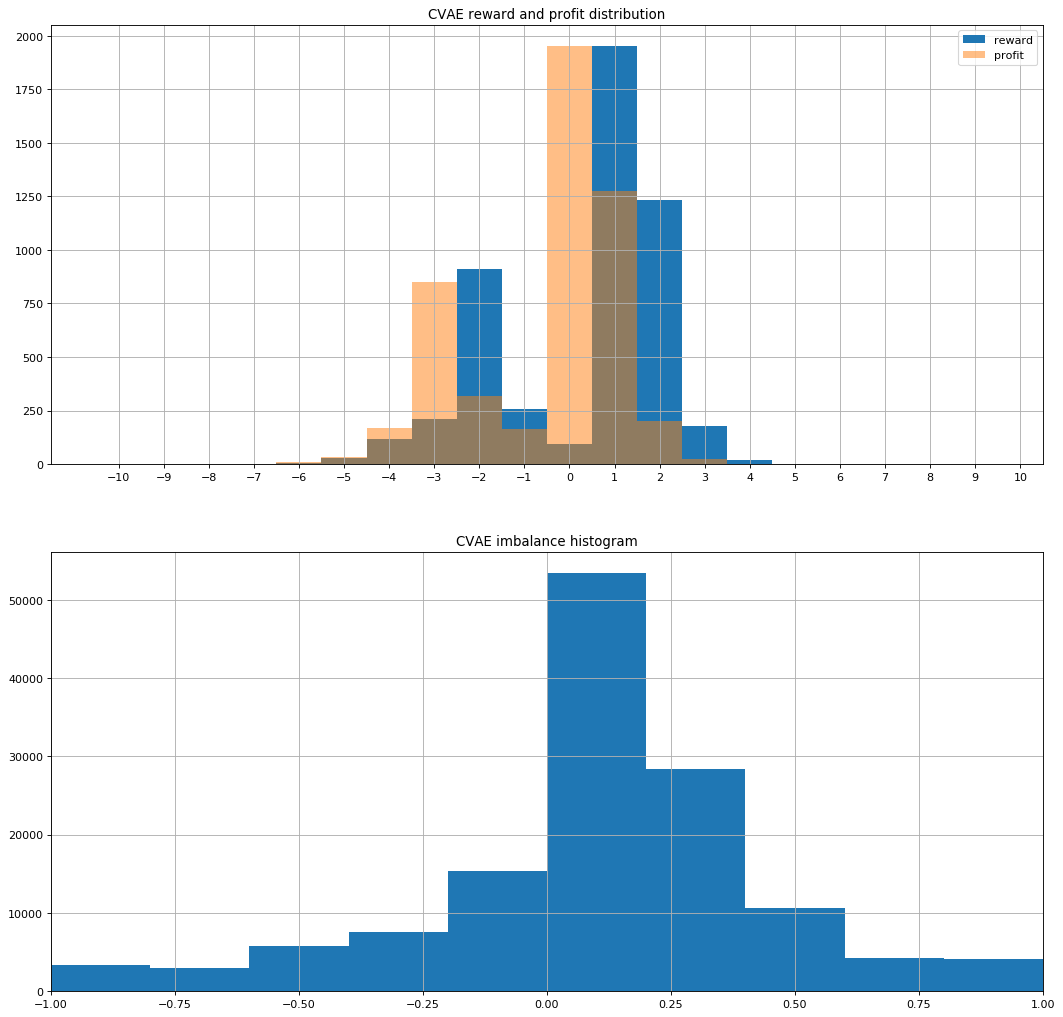

In [21]:
path='Results'
d,memory=experiment.plotbm_results(experiment,'CVAE reward and profit distribution',
                                   'CVAE imbalance histogram',name=experiment.name,path=path)

In [22]:
d.describe()

,reward,profit,start distance,duration
count,5000.000000,5000.000000,5000.00000,5000.000000
mean,0.415916,-0.495800,0.09638,27.136400
std,1.808999,1.681353,0.02042,24.396787
min,-6.468367,-9.000000,-0.10000,1.000000
25%,-1.526896,-2.000000,0.10000,9.000000
50%,1.032865,0.000000,0.10000,18.000000
75%,1.993960,1.000000,0.10000,37.000000
max,6.135858,5.000000,0.10000,100.000000


In [23]:
memory.n_inventory.value_counts(), memory.action.value_counts()

(1.0    131482
 0.0      3437
 2.0       763
 Name: n_inventory, dtype: int64, 2.0    96770
 3.0    24316
 0.0     5763
 1.0     5365
 4.0     3468
 Name: action, dtype: int64)

In [24]:
clf,train_score,test_score,importances=experiment.fit_tree(memory,os.path.join('Results',experiment.name),experiment)

In [25]:
train_score,test_score

(0.8499548984665478, 0.8496515990709309)

In [26]:
importances

,obs_name,importance
0,distance,0.267646
1,inventory,0.000000
2,orders_out,0.000000
3,bid_change,0.000000
4,ask_change,0.000000
5,bid_ask_spread,0.245509
6,position_in_lob,0.113204
7,imbalance,0.373642
8,time_left,0.000000
